## Predict ICU Facilities given COVID-19 cases

ICU COVID - MAE: 1.5359634498236614, MSE: 10.0938358127605, RMSE: 3.177079761787623
ICU PUI - MAE: 0.21449182430266112, MSE: 2.6027893555626807, RMSE: 1.6133162602424487
ICU Non-COVID - MAE: 2.758807310035268, MSE: 21.54384732285989, RMSE: 4.641535017950408


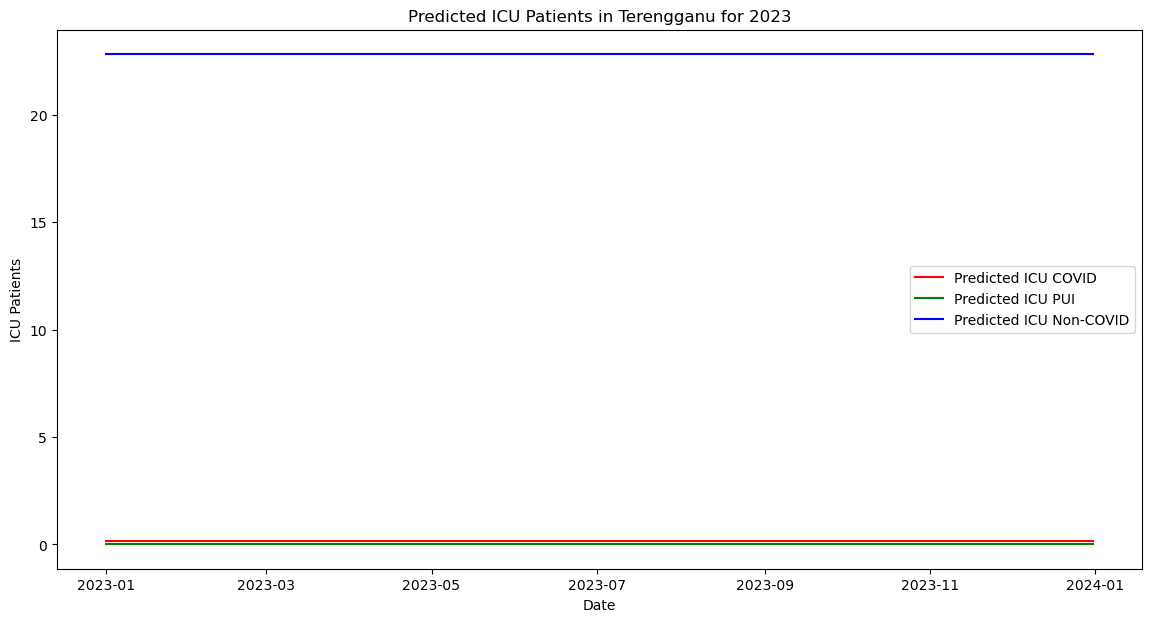

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# Load the data
covid_data = pd.read_csv('filtered_datasets/cases_state.csv', parse_dates=['date'])
hospital_data = pd.read_csv('filtered_datasets/icu.csv', parse_dates=['date'])

# Merge the data on the date and state columns
data = pd.merge(covid_data, hospital_data, on=['date', 'state'])

# Filter data for the years 2020 to 2022
data = data[(data['date'] >= '2020-01-01') & (data['date'] <= '2022-12-31')]

# Sort the data by date
data = data.sort_values(by=['state', 'date'])

# Create lag features
def create_lag_features(data, lag=14):
    for i in range(1, lag + 1):
        data[f'cases_new_lag_{i}'] = data.groupby('state')['cases_new'].shift(i)
        data[f'icu_covid_lag_{i}'] = data.groupby('state')['icu_covid'].shift(i)
        data[f'icu_pui_lag_{i}'] = data.groupby('state')['icu_pui'].shift(i)
        data[f'icu_noncovid_lag_{i}'] = data.groupby('state')['icu_noncovid'].shift(i)
    return data

# Apply the function to create lag features
data = create_lag_features(data)

# Drop rows with missing values (due to lagging)
data = data.dropna()

# Select the features and targets
features = [col for col in data.columns if 'lag' in col]
targets = ['icu_covid', 'icu_pui', 'icu_noncovid']

# Split the data into training and testing sets
X = data[features]
y_covid = data['icu_covid']
y_pui = data['icu_pui']
y_noncovid = data['icu_noncovid']

X_train, X_test, y_covid_train, y_covid_test = train_test_split(X, y_covid, test_size=0.2, random_state=42)
_, _, y_pui_train, y_pui_test = train_test_split(X, y_pui, test_size=0.2, random_state=42)
_, _, y_noncovid_train, y_noncovid_test = train_test_split(X, y_noncovid, test_size=0.2, random_state=42)

# Scale the features
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize the random forest regressor
model_covid = RandomForestRegressor(n_estimators=100, random_state=42)
model_pui = RandomForestRegressor(n_estimators=100, random_state=42)
model_noncovid = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the models
model_covid.fit(X_train, y_covid_train)
model_pui.fit(X_train, y_pui_train)
model_noncovid.fit(X_train, y_noncovid_train)

# Make predictions
y_covid_pred = model_covid.predict(X_test)
y_pui_pred = model_pui.predict(X_test)
y_noncovid_pred = model_noncovid.predict(X_test)

# Evaluate the models
mae_covid = mean_absolute_error(y_covid_test, y_covid_pred)
mse_covid = mean_squared_error(y_covid_test, y_covid_pred)
rmse_covid = np.sqrt(mse_covid)

mae_pui = mean_absolute_error(y_pui_test, y_pui_pred)
mse_pui = mean_squared_error(y_pui_test, y_pui_pred)
rmse_pui = np.sqrt(mse_pui)

mae_noncovid = mean_absolute_error(y_noncovid_test, y_noncovid_pred)
mse_noncovid = mean_squared_error(y_noncovid_test, y_noncovid_pred)
rmse_noncovid = np.sqrt(mse_noncovid)

print(f'ICU COVID - MAE: {mae_covid}, MSE: {mse_covid}, RMSE: {rmse_covid}')
print(f'ICU PUI - MAE: {mae_pui}, MSE: {mse_pui}, RMSE: {rmse_pui}')
print(f'ICU Non-COVID - MAE: {mae_noncovid}, MSE: {mse_noncovid}, RMSE: {rmse_noncovid}')

# Predicting ICU usage for 2023
# Create a DataFrame for 2023 dates
future_dates = pd.date_range(start='2023-01-01', end='2023-12-31', freq='D')
states = data['state'].unique()
future_data = pd.DataFrame([(date, state) for date in future_dates for state in states], columns=['date', 'state'])

# Initialize lag features with NaN
for lag in range(1, 15):
    future_data[f'cases_new_lag_{lag}'] = np.nan
    future_data[f'icu_covid_lag_{lag}'] = np.nan
    future_data[f'icu_pui_lag_{lag}'] = np.nan
    future_data[f'icu_noncovid_lag_{lag}'] = np.nan

# Fill in the lag features with the most recent data from 2022
for state in states:
    state_data = data[data['state'] == state]
    for lag in range(1, 15):
        future_data.loc[future_data['state'] == state, f'cases_new_lag_{lag}'] = state_data['cases_new'].iloc[-lag]
        future_data.loc[future_data['state'] == state, f'icu_covid_lag_{lag}'] = state_data['icu_covid'].iloc[-lag]
        future_data.loc[future_data['state'] == state, f'icu_pui_lag_{lag}'] = state_data['icu_pui'].iloc[-lag]
        future_data.loc[future_data['state'] == state, f'icu_noncovid_lag_{lag}'] = state_data['icu_noncovid'].iloc[-lag]

# Predict the ICU usage for 2023
future_features = future_data[features]
future_features_scaled = scaler.transform(future_features)

future_data['icu_covid_pred'] = model_covid.predict(future_features_scaled)
future_data['icu_pui_pred'] = model_pui.predict(future_features_scaled)
future_data['icu_noncovid_pred'] = model_noncovid.predict(future_features_scaled)

# Plot the predicted ICU usage for 2023 for a specific state
state_to_plot = 'Terengganu'
state_future_data = future_data[future_data['state'] == state_to_plot]

plt.figure(figsize=(14, 7))
plt.plot(state_future_data['date'], state_future_data['icu_covid_pred'], label='Predicted ICU COVID', color='red')
plt.plot(state_future_data['date'], state_future_data['icu_pui_pred'], label='Predicted ICU PUI', color='green')
plt.plot(state_future_data['date'], state_future_data['icu_noncovid_pred'], label='Predicted ICU Non-COVID', color='blue')
plt.xlabel('Date')
plt.ylabel('ICU Patients')
plt.title(f'Predicted ICU Patients in {state_to_plot} for 2023')
plt.legend()
plt.show()
